# If there's something strange in you accounting department, who you gonna call?

Some initialization to make life easier.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

[Pandas](https://pandas.pydata.org) is the most important workhorse in data analytics.

In [2]:
import pandas as pd

We have downloaded two tables from the SAP system:
1. The line items are stored in the table `BSEG`
2. The header information is stored in the table `BKPF`

In [3]:
bseg = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/BSEG.csv',low_memory=False)
bkpf = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/BKPF.csv', low_memory=False)

Both tables from with huge numbers of columns.

In [4]:
bseg.columns

Index(['Unnamed: 0', 'MANDT', 'BUKRS', 'BELNR', 'GJAHR', 'BUZEI', 'BUZID',
       'AUGDT', 'AUGCP', 'AUGBL',
       ...
       'PEROP_END', 'FASTPAY', 'IGNR_IVREF', 'FMFGUS_KEY', 'FMXDOCNR',
       'FMXYEAR', 'FMXDOCLN', 'FMXZEKKN', 'PRODPER', 'RECRF'],
      dtype='object', length=337)

In [5]:
bkpf.columns

Index(['Unnamed: 0', 'MANDT', 'BUKRS', 'BELNR', 'GJAHR', 'BLART', 'BLDAT',
       'BUDAT', 'MONAT', 'CPUDT',
       ...
       'SSBLK', 'BATCH', 'SNAME', 'SAMPLED', 'EXCLUDE_FLAG', 'BLIND',
       'OFFSET_STATUS', 'OFFSET_REFER_DAT', 'PENRC', 'KNUMV'],
      dtype='object', length=114)

You can find the definition of all the columns using the transaction code `SE16`.

## BKPF

For our purposes, we use the following columns from `BKPF`:
* `BELNR` - That is the financial document number
* `BLART` - That is the document type
* `USNAM` - That is the user who posted the financial document

In [6]:
bkpf = bkpf.loc[:, ['BELNR', 'BLART','USNAM']]

In [7]:
bkpf.sample(10, random_state=456)

,BELNR,BLART,USNAM
887,4900000573,WA,BOETTCHER
1183,4900000869,WA,BOETTCHER
2547,5000000184,WE,GBIFAC-01
690,4900000376,WA,BOETTCHER
1280,4900000966,WA,BOETTCHER
19,1500000013,KZ,GBI-005
2778,5000000415,WE,GBI-005
2266,4900001952,WA,BOETTCHER
1013,4900000699,WA,BOETTCHER
3262,1500000304,KZ,GBIFAC-01


In [8]:
bkpf['BLART'].unique()

array(['RV', 'DZ', 'KZ', 'KG', 'WA', 'WL', 'WE', 'RE'], dtype=object)

Interesting for us is the document type `KZ`, which represents vendor payments.

In [9]:
bkpf = bkpf[bkpf['BLART']=='KZ']

## BSEG

We use the following columns from `BSEG`:
* `BELNR` - That is the financial document number
* `BSCHL` - That is the posting key
* `WRBTR` - That is the amount posted
* `LIFNR` - That is vendor account

In [10]:
bseg = bseg.loc[:, ['BELNR', 'BSCHL', 'WRBTR', 'LIFNR']]

In [11]:
bseg.sample(10, random_state=456)

,BELNR,BSCHL,WRBTR,LIFNR
559,1.500000e+09,25,"1,000.00",125131.0
235,1.500000e+09,50,5,NaN
619,1.700000e+09,35,"1,960,000.00",125088.0
32,1.500000e+09,50,"1,010,000.00",NaN
2737,1.500000e+09,50,1927.48,NaN
425,1.500000e+09,50,"1,000,000.00",NaN
2527,5.105600e+09,31,"96,000.00",125108.0
2808,1.500000e+09,25,"1,000.00",125107.0
943,5.000000e+09,96,"63,830.00",125018.0
557,1.500000e+09,25,"1,000.00",125131.0


In [12]:
bseg['BSCHL'].unique()

array([50, 25, 40, 35, 89, 96, 86, 99, 81, 91, 31, 83, 93, 21])

Interesting for us is the posting key `25`, which represents the debit posting on the vendor account.

In [13]:
bseg = bseg[bseg['BSCHL']==25]

In [14]:
bseg.dtypes

BELNR    float64
BSCHL      int64
WRBTR     object
LIFNR    float64
dtype: object

We need to fix the posting value.

In [15]:
bseg['WRBTR'] = bseg['WRBTR'].str.replace(',','')

In [16]:
bseg.head()

,BELNR,BSCHL,WRBTR,LIFNR
1,1.500000e+09,25,213710.00,125131.0
3,1.500000e+09,25,1068550.00,125131.0
5,1.500000e+09,25,933153.41,125135.0
7,1.500000e+09,25,1050.00,125135.0
9,1.500000e+09,25,30300.00,125131.0


## First digit of the posting value

In [17]:
bseg['first'] = bseg['WRBTR'].str[0:1].astype(int)

## How many documents do we have per vendor?

In [18]:
vendors = bseg.groupby('LIFNR').size().sort_values(ascending=False)
vendors

LIFNR
125131.0    122
125135.0    118
125134.0     47
125104.0     31
125107.0     22
125105.0      4
125121.0      3
125000.0      1
125014.0      1
125070.0      1
125098.0      1
125101.0      1
125127.0      1
dtype: int64

In [19]:
vendors = vendors[vendors > 20]
vendors

LIFNR
125131.0    122
125135.0    118
125134.0     47
125104.0     31
125107.0     22
dtype: int64

In [20]:
vendors.index

Float64Index([125131.0, 125135.0, 125134.0, 125104.0, 125107.0], dtype='float64', name='LIFNR')

In [21]:
bseg = bseg[bseg['LIFNR'].isin(vendors.index)]

In [22]:
bseg.head()
bkpf.head()

,BELNR,BLART,USNAM
6,1500000000,KZ,GBI-005
7,1500000001,KZ,GBI-005
8,1500000002,KZ,GBI-005
9,1500000003,KZ,GBI-005
10,1500000004,KZ,GBI-005


## Integrated dataset

In [23]:
vp = pd.merge(bseg, bkpf, how='left', on='BELNR')

In [24]:
ben_vp_vendor = vp.groupby(['first', 'LIFNR'])['first'].count().reset_index(name='count')
ben_vp_vendor.head()

,first,LIFNR,count
0,1,125104.0,2
1,1,125107.0,20
2,1,125131.0,72
3,1,125134.0,3
4,1,125135.0,74


In [25]:
ben_vp_accountant = vp.groupby(['first', 'USNAM'])['first'].count().reset_index(name='count')
ben_vp_accountant.head()

,first,USNAM,count
0,1,GBI-005,28
1,1,GBI-026,83
2,1,GBIFAC-01,59
3,2,GBI-005,17
4,2,GBI-026,7


## Benford Analysis

In [26]:
import math
benford = [math.log10(1 + 1 / d)*100 for d in range(1,10)]
d = {'n': range(1,10), 'b': benford}
ben_predict = pd.DataFrame(d)

In [27]:
import seaborn as sns

### Posting value by vendor

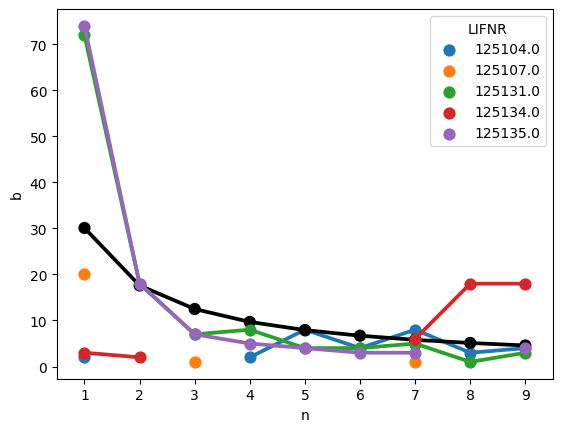

In [28]:
sns.pointplot(x='first', y='count', hue='LIFNR',data=ben_vp_vendor)
sns.pointplot(x='n', y='b' ,data=ben_predict, color='black');

### Posting value by accountant

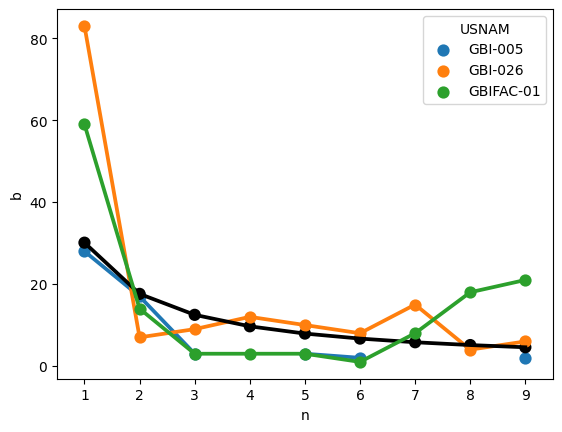

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pointplot(x='first', y='count', hue='USNAM',data=ben_vp_accountant)
sns.pointplot(x='n', y='b' ,data=ben_predict, color='black');

## Who is this GBIFAC-01 and what happened?

In [30]:
len(vp[(vp['USNAM']=='GBIFAC-01') & (vp['first'].isin([7,8,9])) & (vp['LIFNR'] != 125134)])

5

In [31]:
len(vp[(vp['USNAM']=='GBIFAC-01') & (vp['first'].isin([7,8,9])) & (vp['LIFNR'] == 125134)])

42

In [32]:
len(vp[(vp['USNAM']=='GBIFAC-01') & ~(vp['first'].isin([7,8,9])) & (vp['LIFNR'] == 125134)])

4

In [33]:
len(vp[(vp['USNAM']=='GBIFAC-01')])

130

In [34]:
vp[(vp['USNAM']=='GBIFAC-01') & (vp['first'].isin([7,8,9])) & (vp['LIFNR'] == 125134)]['WRBTR'].astype(float).sum()

3697715.58

In [35]:
vp[(vp['USNAM']=='GBIFAC-01') & ~(vp['first'].isin([7,8,9])) & (vp['LIFNR'] == 125134)]['WRBTR'].astype(float).sum()

59659.58

**We need to talk to GBIFAC-01!**